In [17]:
# ============================================
# 📦 PASSO 1: INSTALAÇÃO DE TODAS AS BIBLIOTECAS
# ============================================

print("🚀 INSTALANDO BIBLIOTECAS NECESSÁRIAS...")
print("="*60)

!pip install numpy pandas matplotlib scikit-learn -q
print("✅ numpy, pandas, matplotlib, scikit-learn instalados")

!pip install torch -q
print("✅ PyTorch instalado")

!pip install plotly -q
print("✅ plotly instalado")

!pip install git+https://github.com/jxx123/simglucose.git -q
print("✅ simglucose (base para fisiologia) instalado")

print("\n" + "="*60)
print("📦 TODAS AS DEPENDÊNCIAS INSTALADAS!")
print("="*60)

🚀 INSTALANDO BIBLIOTECAS NECESSÁRIAS...
✅ numpy, pandas, matplotlib, scikit-learn instalados
✅ PyTorch instalado
✅ plotly instalado
  Preparing metadata (setup.py) ... done
✅ simglucose (base para fisiologia) instalado

📦 TODAS AS DEPENDÊNCIAS INSTALADAS!


In [18]:
# ============================================
# 📚 PASSO 2: IMPORTAÇÃO DE TODAS AS BIBLIOTECAS
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# Para visualização
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Para machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Para simulação
from scipy.integrate import odeint

print(f"📊 Versões carregadas:")
print(f"  • numpy {np.__version__}")
print(f"  • pandas {pd.__version__}")
print(f"  • PyTorch {torch.__version__}")
print("\n✅ Todas as bibliotecas importadas com sucesso!")

📊 Versões carregadas:
  • numpy 2.0.2
  • pandas 2.2.2
  • PyTorch 2.9.0+cpu

✅ Todas as bibliotecas importadas com sucesso!



🧪 TESTANDO MODELO DALLA MAN DM2...
🧬 Modelo Dalla Man DM2 criado para: moderate
   Glicose basal: 140 mg/dL
   Insulina basal: 12 mU/L
✅ Modelo testado com sucesso!
📊 Glicose inicial: 140.1 mg/dL
📊 Glicose final: 123.7 mg/dL


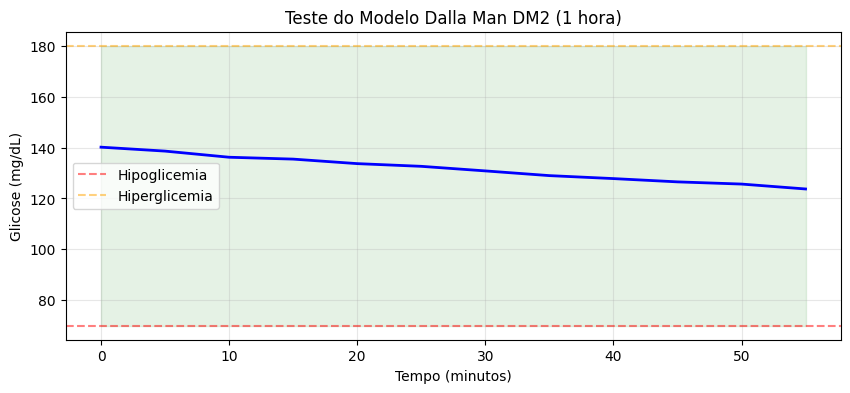

In [19]:
# ============================================
# 🧬 PASSO 3: MODELO DALLA MAN MODIFICADO PARA DM2
# ============================================

class ModifiedDallaManDM2:
    """
    Implementação do modelo Dalla Man modificado para Diabetes Tipo 2
    Versão simplificada e funcional para simulação em tempo real
    """

    def __init__(self, patient_type='moderate'):
        self.patient_type = patient_type

        # Parâmetros por tipo de paciente (DM2)
        self.params = self._get_patient_params(patient_type)

        # Estado inicial
        self.state = {
            'glucose': self.params['Gb'],  # mg/dL
            'insulin': self.params['Ib'],  # mU/L
            'carbs_gut': 0,  # carboidratos no intestino
            'insulin_sc': 0  # insulina subcutânea
        }

        print(f"🧬 Modelo Dalla Man DM2 criado para: {patient_type}")
        print(f"   Glicose basal: {self.params['Gb']} mg/dL")
        print(f"   Insulina basal: {self.params['Ib']} mU/L")

    def _get_patient_params(self, patient_type):
        """Retorna parâmetros específicos para cada tipo de paciente DM2"""
        params = {
            'well_controlled': {
                'Gb': 100,    # Glicose basal
                'Ib': 7,      # Insulina basal
                'Si': 0.015,  # Sensibilidade à insulina
                'carb_sens': 2.0,  # Sensibilidade a carboidratos
                'gluc_decay': 0.02,  # Decaimento natural
                'insulin_decay': 0.1,  # Decaimento da insulina
                'meal_response': 1.5,  # Resposta a refeições
                'variability': 5  # Variabilidade aleatória
            },
            'moderate': {
                'Gb': 140,
                'Ib': 12,
                'Si': 0.008,
                'carb_sens': 2.5,
                'gluc_decay': 0.015,
                'insulin_decay': 0.08,
                'meal_response': 2.0,
                'variability': 8
            },
            'poorly_controlled': {
                'Gb': 200,
                'Ib': 20,
                'Si': 0.003,
                'carb_sens': 3.0,
                'gluc_decay': 0.01,
                'insulin_decay': 0.06,
                'meal_response': 2.5,
                'variability': 12
            },
            'elderly_frail': {
                'Gb': 160,
                'Ib': 15,
                'Si': 0.002,
                'carb_sens': 1.8,
                'gluc_decay': 0.008,
                'insulin_decay': 0.05,
                'meal_response': 1.2,
                'variability': 10
            }
        }
        return params.get(patient_type, params['moderate'])

    def simulate_step(self, minutes=5, carbs=0, insulin_injected=0):
        """
        Simula um passo de tempo (equações diferenciais simplificadas)

        minutes: minutos a simular
        carbs: carboidratos consumidos (g)
        insulin_injected: insulina injetada (U)
        """
        # Converter minutos para horas
        dt = minutes / 60.0

        # 1. Efeito dos carboidratos
        if carbs > 0:
            # Carboidratos entram no intestino
            self.state['carbs_gut'] += carbs * self.params['carb_sens']

        # Absorção de carboidratos do intestino para sangue
        carbs_absorbed = self.state['carbs_gut'] * 0.1 * dt
        self.state['carbs_gut'] -= carbs_absorbed

        # 2. Efeito da insulina injetada
        if insulin_injected > 0:
            self.state['insulin_sc'] += insulin_injected * 100  # Converter para mU

        # Liberação de insulina subcutânea para sangue
        insulin_released = self.state['insulin_sc'] * self.params['insulin_decay'] * dt
        self.state['insulin_sc'] -= insulin_released
        self.state['insulin'] += insulin_released

        # 3. Equações principais (simplificadas do Dalla Man)

        # Produção hepática de glicose
        EGP = 1.46 * np.exp(-0.005 * self.state['insulin'])

        # Clearance de glicose
        glucose_clearance = (
            self.params['gluc_decay'] * self.state['glucose'] +
            self.params['Si'] * self.state['insulin'] * self.state['glucose']
        )

        # Taxa de mudança da glicose
        dG_dt = (
            EGP +                    # Produção hepática
            carbs_absorbed * self.params['meal_response'] -  # Carboidratos absorvidos
            glucose_clearance        # Clearance
        ) / 1.88  # Volume de distribuição (Vg)

        # Decaimento da insulina no plasma
        dI_dt = -self.params['insulin_decay'] * self.state['insulin']

        # 4. Atualizar estado
        self.state['glucose'] += dG_dt * dt
        self.state['insulin'] += dI_dt * dt

        # 5. Variação aleatória
        random_change = np.random.normal(0, self.params['variability'] * dt)
        self.state['glucose'] += random_change

        # 6. Limites fisiológicos
        self.state['glucose'] = max(40, min(500, self.state['glucose']))
        self.state['insulin'] = max(0, min(100, self.state['insulin']))
        self.state['carbs_gut'] = max(0, self.state['carbs_gut'])
        self.state['insulin_sc'] = max(0, self.state['insulin_sc'])

        return self.state.copy()

# Testar o modelo
print("\n🧪 TESTANDO MODELO DALLA MAN DM2...")
print("="*60)

try:
    model = ModifiedDallaManDM2('moderate')

    # Simular algumas horas
    results = []
    for i in range(12):  # 12 intervalos de 5 min = 1 hora
        if i == 2:  # Café da manhã
            state = model.simulate_step(minutes=5, carbs=45, insulin_injected=8)
        else:
            state = model.simulate_step(minutes=5)
        results.append(state)

    print(f"✅ Modelo testado com sucesso!")
    print(f"📊 Glicose inicial: {results[0]['glucose']:.1f} mg/dL")
    print(f"📊 Glicose final: {results[-1]['glucose']:.1f} mg/dL")

    # Gráfico rápido
    glucose_values = [r['glucose'] for r in results]
    times = [i*5 for i in range(len(results))]

    plt.figure(figsize=(10, 4))
    plt.plot(times, glucose_values, 'b-', linewidth=2)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Hipoglicemia')
    plt.axhline(y=180, color='orange', linestyle='--', alpha=0.5, label='Hiperglicemia')
    plt.fill_between(times, 70, 180, alpha=0.1, color='green')
    plt.title('Teste do Modelo Dalla Man DM2 (1 hora)')
    plt.xlabel('Tempo (minutos)')
    plt.ylabel('Glicose (mg/dL)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"❌ Erro: {str(e)}")
    import traceback
    traceback.print_exc()


🎓 TREINANDO MODELO LSTM
🧪 Gerando dados de treinamento...
✅ 1000 amostras geradas
📊 Preparando dados: 1000 registros
✅ Dados preparados:
   Features: ['glucose', 'carbs', 'insulin']
   Sequências: (982, 12, 3)
   Predições: (982, 6)

📈 Divisão:
   Treino: 785 sequências
   Teste:  197 sequências

💻 Dispositivo: cpu
🧠 LSTM com atenção criada:
   Input: 3 features
   Hidden: 32 neurônios
   Output: 6 predições

🔥 Treinando...
   Época 2/10, Loss: 0.056075
   Época 4/10, Loss: 0.030294
   Época 6/10, Loss: 0.019390
   Época 8/10, Loss: 0.016353
   Época 10/10, Loss: 0.015819

📊 Teste Loss: 0.009323

🎯 Exemplo de predição:
   Predito: [0.1465452  0.13009408 0.14816087 0.10812205 0.16964476 0.12811139]
   Real:    [0.09089966 0.0582498  0.07021837 0.06511911 0.0871387  0.11546202]


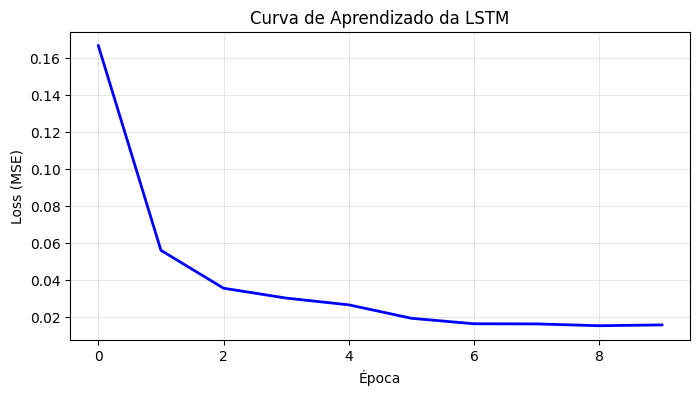


✅ LSTM treinada com sucesso!


In [20]:
# ============================================
# 🧠 PASSO 4: LSTM COM MECANISMO DE ATENÇÃO
# ============================================

class GlucoseLSTM(nn.Module):
    """
    Rede Neural LSTM com mecanismo de atenção para predição glicêmica
    """

    def __init__(self, input_size=4, hidden_size=32, num_layers=1, output_size=6):
        super(GlucoseLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Camada LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )

        # Mecanismo de atenção
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Camadas fully connected
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, output_size)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        print(f"🧠 LSTM com atenção criada:")
        print(f"   Input: {input_size} features")
        print(f"   Hidden: {hidden_size} neurônios")
        print(f"   Output: {output_size} predições")

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        batch_size = x.size(0)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Atenção
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)

        # Context vector
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Fully connected
        out = self.relu(self.fc1(context))
        out = self.dropout(out)
        out = self.fc2(out)

        return out, attention_weights.squeeze()

class DataPreparer:
    """Prepara dados para a LSTM"""

    def __init__(self, seq_length=12, pred_horizon=6):
        self.seq_length = seq_length
        self.pred_horizon = pred_horizon
        self.scalers = {}

    def prepare_data(self, df, features=None):
        """Prepara dados para treinamento"""
        if features is None:
            features = ['glucose', 'carbs', 'insulin', 'hour_sin']

        print(f"📊 Preparando dados: {len(df)} registros")

        # Adicionar features temporais
        if 'timestamp' in df.columns:
            df['hour'] = df['timestamp'].dt.hour
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)

        # Normalizar
        scaled_data = []
        available_features = []

        for feature in features:
            if feature in df.columns:
                scaler = MinMaxScaler()
                data = df[feature].fillna(0).values.reshape(-1, 1)
                scaled = scaler.fit_transform(data)
                self.scalers[feature] = scaler
                scaled_data.append(scaled)
                available_features.append(feature)

        if not scaled_data:
            print("❌ Nenhuma feature disponível")
            return np.array([]), np.array([])

        # Combinar features
        X_data = np.hstack(scaled_data)

        # Criar sequências
        X, y = [], []

        for i in range(len(X_data) - self.seq_length - self.pred_horizon):
            X.append(X_data[i:i + self.seq_length])
            y.append(X_data[i + self.seq_length:i + self.seq_length + self.pred_horizon, 0])  # Só glicose

        if len(X) == 0:
            print("❌ Sequências insuficientes")
            return np.array([]), np.array([])

        X_array = np.array(X)
        y_array = np.array(y)

        print(f"✅ Dados preparados:")
        print(f"   Features: {available_features}")
        print(f"   Sequências: {X_array.shape}")
        print(f"   Predições: {y_array.shape}")

        return X_array, y_array

    def prepare_recent_data(self, recent_values):
        """Prepara dados recentes para predição"""
        if len(recent_values) < self.seq_length:
            print(f"⚠️ Dados insuficientes: {len(recent_values)} < {self.seq_length}")
            return None

        # Normalizar
        scaled_seq = []
        for i, (feature, scaler) in enumerate(self.scalers.items()):
            if i < recent_values.shape[1]:
                data = recent_values[:, i:i+1]
                scaled = scaler.transform(data)
                scaled_seq.append(scaled)

        return np.hstack(scaled_seq).reshape(1, self.seq_length, -1)

def generate_training_data():
    """Gera dados sintéticos para treinamento"""
    print("🧪 Gerando dados de treinamento...")

    n_samples = 1000
    timestamps = pd.date_range(start='2024-01-01', periods=n_samples, freq='5min')

    # Glicose base com padrão circadiano
    base_glucose = 120 + 20 * np.sin(2 * np.pi * np.arange(n_samples) / (24*12))

    # Refeições periódicas
    meal_effects = np.zeros(n_samples)
    for i in range(0, n_samples, 48):  # A cada 4 horas
        effect = np.random.uniform(30, 50)
        duration = np.random.randint(6, 12)
        meal_effects[i:i+duration] = effect * np.exp(-np.arange(duration)/3)

    # Insulina
    insulin = np.zeros(n_samples)
    insulin_effects = np.zeros(n_samples)
    for i in range(0, n_samples, 48):
        if np.random.random() > 0.3:
            insulin[i+1] = np.random.uniform(5, 12)
            # Efeito da insulina
            for j in range(12):
                if i+1+j < n_samples:
                    insulin_effects[i+1+j] -= insulin[i+1] * np.exp(-j/3)

    # Combinar tudo
    glucose = base_glucose + meal_effects + insulin_effects
    glucose += np.random.normal(0, 3, n_samples)
    glucose = np.clip(glucose, 60, 300)

    # Carboidratos
    carbs = np.zeros(n_samples)
    carbs[meal_effects > 5] = np.random.uniform(20, 40, np.sum(meal_effects > 5))

    # DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'glucose': glucose,
        'carbs': carbs,
        'insulin': insulin
    })

    print(f"✅ {len(df)} amostras geradas")
    return df

def train_lstm_model():
    """Treina o modelo LSTM"""
    print("\n" + "="*60)
    print("🎓 TREINANDO MODELO LSTM")
    print("="*60)

    try:
        # Gerar dados
        data = generate_training_data()

        # Preparar dados
        preparer = DataPreparer(seq_length=12, pred_horizon=6)
        features = ['glucose', 'carbs', 'insulin']

        X, y = preparer.prepare_data(data, features)

        if len(X) == 0:
            print("❌ Falha ao preparar dados")
            return None, None

        # Dividir treino/teste
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"\n📈 Divisão:")
        print(f"   Treino: {len(X_train)} sequências")
        print(f"   Teste:  {len(X_test)} sequências")

        # Criar modelo
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\n💻 Dispositivo: {device}")

        model = GlucoseLSTM(
            input_size=len(features),
            hidden_size=32,
            num_layers=1,
            output_size=6
        ).to(device)

        # Configurar treinamento
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Converter para tensores
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)

        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Treinar
        print("\n🔥 Treinando...")
        model.train()
        losses = []

        for epoch in range(10):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                predictions, _ = model(batch_X)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)

            if (epoch + 1) % 2 == 0:
                print(f"   Época {epoch+1}/10, Loss: {avg_loss:.6f}")

        # Avaliar
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            test_pred, test_attn = model(X_test_tensor)
            test_loss = criterion(test_pred, torch.FloatTensor(y_test).to(device))

            print(f"\n📊 Teste Loss: {test_loss.item():.6f}")

            # Exemplo
            sample_pred = test_pred[0].cpu().numpy()
            sample_true = y_test[0]

            print(f"\n🎯 Exemplo de predição:")
            print(f"   Predito: {sample_pred}")
            print(f"   Real:    {sample_true}")

        # Gráfico de loss
        plt.figure(figsize=(8, 4))
        plt.plot(losses, 'b-', linewidth=2)
        plt.title('Curva de Aprendizado da LSTM')
        plt.xlabel('Época')
        plt.ylabel('Loss (MSE)')
        plt.grid(True, alpha=0.3)
        plt.show()

        print("\n✅ LSTM treinada com sucesso!")
        return model, preparer

    except Exception as e:
        print(f"❌ Erro no treinamento: {str(e)}")
        return None, None

# Treinar a LSTM
trained_model, data_preparer = train_lstm_model()

In [21]:
# ============================================
# ⚠️ PASSO 5: SISTEMA DE ALERTAS CLÍNICOS
# ============================================

class ClinicalAlertSystem:
    """
    Sistema de alertas baseado em protocolos médicos para DM2
    """

    def __init__(self, patient_type='moderate'):
        self.patient_type = patient_type
        self.thresholds = self._get_thresholds(patient_type)
        self.alert_history = []

        print(f"⚠️ Sistema de alertas criado para {patient_type}")

    def _get_thresholds(self, patient_type):
        """Define limiares clínicos"""
        thresholds = {
            'well_controlled': {
                'critical_hypo': 60,
                'hypo': 70,
                'target_low': 70,
                'target_high': 140,
                'hyper': 180,
                'critical_hyper': 250,
                'rapid_fall': -15,  # mg/dL por 15min
                'rapid_rise': 20
            },
            'moderate': {
                'critical_hypo': 55,
                'hypo': 70,
                'target_low': 70,
                'target_high': 180,
                'hyper': 250,
                'critical_hyper': 300,
                'rapid_fall': -20,
                'rapid_rise': 30
            },
            'poorly_controlled': {
                'critical_hypo': 50,
                'hypo': 60,
                'target_low': 70,
                'target_high': 200,
                'hyper': 300,
                'critical_hyper': 350,
                'rapid_fall': -25,
                'rapid_rise': 40
            },
            'elderly_frail': {
                'critical_hypo': 60,
                'hypo': 70,
                'target_low': 80,
                'target_high': 200,
                'hyper': 250,
                'critical_hyper': 300,
                'rapid_fall': -15,
                'rapid_rise': 25
            }
        }
        return thresholds.get(patient_type, thresholds['moderate'])

    def check_alerts(self, current_glucose, glucose_history=None, predictions=None):
        """Verifica e retorna alertas"""
        alerts = []

        # 1. Alertas baseados no valor atual
        if current_glucose <= self.thresholds['critical_hypo']:
            alerts.append(self._create_alert(
                'CRITICAL_HYPOGLYCEMIA',
                f'🚨 HIPOGLICEMIA SEVERA: {current_glucose:.1f} mg/dL',
                'Ingerir 20g de carboidratos IMEDIATAMENTE. Verificar em 15 min.',
                'CRITICAL'
            ))

        elif current_glucose <= self.thresholds['hypo']:
            alerts.append(self._create_alert(
                'HYPOGLYCEMIA',
                f'⚠️ Hipoglicemia: {current_glucose:.1f} mg/dL',
                'Consumir 15g de carboidratos de ação rápida.',
                'HIGH'
            ))

        elif current_glucose >= self.thresholds['critical_hyper']:
            alerts.append(self._create_alert(
                'CRITICAL_HYPERGLYCEMIA',
                f'🚨 HIPERGLICEMIA SEVERA: {current_glucose:.1f} mg/dL',
                'Verificar cetonas. Contatar médico urgente.',
                'CRITICAL'
            ))

        elif current_glucose >= self.thresholds['hyper']:
            alerts.append(self._create_alert(
                'HYPERGLYCEMIA',
                f'⚠️ Hiperglicemia: {current_glucose:.1f} mg/dL',
                'Considerar dose corretiva de insulina (consultar plano).',
                'MEDIUM'
            ))

        # 2. Alertas baseados em tendência
        if glucose_history and len(glucose_history) >= 3:
            trend = self._calculate_trend(glucose_history[-3:])

            if trend <= self.thresholds['rapid_fall']:
                alerts.append(self._create_alert(
                    'RAPID_FALL',
                    f'📉 Queda rápida: {trend:.1f} mg/dL/15min',
                    'Suspender atividade. Considerar lanche preventivo.',
                    'MEDIUM'
                ))

            elif trend >= self.thresholds['rapid_rise']:
                alerts.append(self._create_alert(
                    'RAPID_RISE',
                    f'📈 Subida rápida: {trend:.1f} mg/dL/15min',
                    'Verificar se esqueceu insulina. Avaliar refeição.',
                    'MEDIUM'
                ))

        # 3. Alertas preditivos
        if predictions is not None and len(predictions) >= 4:
            # Verificar se alguma predição indica hipoglicemia
            for i, pred in enumerate(predictions[:4]):  # Primeiras 20 min
                if pred <= self.thresholds['hypo']:
                    time_min = (i + 1) * 5
                    alerts.append(self._create_alert(
                        'PREDICTED_HYPOGLYCEMIA',
                        f'🔮 Predição: Hipoglicemia em {time_min} min ({pred:.1f} mg/dL)',
                        f'Considerar lanche preventivo de 10-15g de carboidratos.',
                        'MEDIUM'
                    ))
                    break

        # Registrar no histórico
        for alert in alerts:
            alert['timestamp'] = datetime.now()
            self.alert_history.append(alert)

        # Limitar histórico
        if len(self.alert_history) > 50:
            self.alert_history = self.alert_history[-50:]

        return alerts

    def _calculate_trend(self, recent_values):
        """Calcula tendência (mg/dL por 15 minutos)"""
        if len(recent_values) < 2:
            return 0

        times = np.arange(len(recent_values))
        slope, _ = np.polyfit(times, recent_values, 1)
        return slope * 3  # Converter para 15 minutos

    def _create_alert(self, alert_type, message, action, priority):
        """Cria objeto de alerta"""
        return {
            'type': alert_type,
            'message': message,
            'action': action,
            'priority': priority,
            'acknowledged': False
        }

# Testar sistema de alertas
print("\n" + "="*60)
print("⚠️ TESTANDO SISTEMA DE ALERTAS")
print("="*60)

alert_sys = ClinicalAlertSystem('moderate')

# Teste 1: Valores normais
print("\n🧪 Teste 1 - Glicose normal (120 mg/dL):")
alerts = alert_sys.check_alerts(120)
print(f"   Alertas: {len(alerts)}")

# Teste 2: Hipoglicemia
print("\n🧪 Teste 2 - Hipoglicemia (65 mg/dL):")
alerts = alert_sys.check_alerts(65)
for alert in alerts:
    print(f"   {alert['priority']}: {alert['message']}")

# Teste 3: Hiperglicemia
print("\n🧪 Teste 3 - Hiperglicemia (280 mg/dL):")
alerts = alert_sys.check_alerts(280, glucose_history=[250, 265, 280])
for alert in alerts:
    print(f"   {alert['priority']}: {alert['message']}")

print("\n✅ Sistema de alertas testado com sucesso!")


⚠️ TESTANDO SISTEMA DE ALERTAS
⚠️ Sistema de alertas criado para moderate

🧪 Teste 1 - Glicose normal (120 mg/dL):
   Alertas: 0

🧪 Teste 2 - Hipoglicemia (65 mg/dL):
   HIGH: ⚠️ Hipoglicemia: 65.0 mg/dL

🧪 Teste 3 - Hiperglicemia (280 mg/dL):
   MEDIUM: ⚠️ Hiperglicemia: 280.0 mg/dL
   MEDIUM: 📈 Subida rápida: 45.0 mg/dL/15min

✅ Sistema de alertas testado com sucesso!


In [22]:
# ============================================
# 👤 PASSO 6: PACIENTE VIRTUAL EM TEMPO REAL
# ============================================

class VirtualPatient:
    """
    Paciente virtual que simula um paciente DM2 em tempo real
    Integra todos os componentes: Dalla Man + LSTM + Alertas
    """

    def __init__(self, name="Maria", patient_type="moderate"):
        self.name = name
        self.patient_type = patient_type
        self.current_time = datetime.now()

        print(f"\n" + "="*60)
        print(f"👤 CRIANDO PACIENTE VIRTUAL: {name}")
        print(f"🏥 TIPO: {patient_type}")
        print("="*60)

        # 1. Modelo fisiológico
        print("🧬 Inicializando modelo Dalla Man...")
        self.physio_model = ModifiedDallaManDM2(patient_type)

        # 2. Sistema de alertas
        print("⚠️ Inicializando sistema de alertas...")
        self.alert_system = ClinicalAlertSystem(patient_type)

        # 3. LSTM (se disponível)
        self.lstm_model = trained_model
        self.data_preparer = data_preparer

        # 4. Histórico de dados
        self.history = []
        self.glucose_history = []
        self.events_history = []

        # 5. Comportamento
        self.schedule = {
            'meals': [
                {'time': 8, 'carbs': 45, 'insulin': 8},
                {'time': 13, 'carbs': 60, 'insulin': 10},
                {'time': 20, 'carbs': 50, 'insulin': 8}
            ],
            'adherence': 0.7 if patient_type == 'moderate' else 0.9 if patient_type == 'well_controlled' else 0.5
        }

        # Estado inicial
        initial_state = self.physio_model.simulate_step(minutes=0)
        self.current_glucose = initial_state['glucose']
        self.current_insulin = initial_state['insulin']

        print(f"\n✅ Paciente '{name}' criado com sucesso!")
        print(f"📊 Glicose inicial: {self.current_glucose:.1f} mg/dL")

    def simulate_minutes(self, minutes=5):
        """Simula a passagem do tempo"""
        self.current_time += timedelta(minutes=minutes)
        hour = self.current_time.hour
        minute = self.current_time.minute

        # Verificar eventos
        events = []
        carbs_to_eat = 0
        insulin_to_inject = 0

        for meal in self.schedule['meals']:
            if hour == meal['time'] and minute == 0:
                carbs_to_eat = meal['carbs']
                events.append(f"Refeição: {carbs_to_eat}g carboidratos")

                # Tomar insulina (com aderência)
                if np.random.random() < self.schedule['adherence']:
                    insulin_to_inject = meal['insulin']
                    events.append(f"Injeção: {insulin_to_inject}U insulina")

        # Simular fisiologia
        state = self.physio_model.simulate_step(
            minutes=minutes,
            carbs=carbs_to_eat,
            insulin_injected=insulin_to_inject
        )

        # Atualizar estado atual
        self.current_glucose = state['glucose']
        self.current_insulin = state['insulin']

        # Registrar no histórico
        record = {
            'timestamp': self.current_time,
            'glucose': self.current_glucose,
            'insulin': self.current_insulin,
            'events': events,
            'carbs': carbs_to_eat,
            'insulin_injected': insulin_to_inject
        }

        self.history.append(record)
        self.glucose_history.append(self.current_glucose)
        if events:
            self.events_history.extend(events)

        # Limitar histórico
        if len(self.history) > 288:  # 24 horas
            self.history = self.history[-288:]
            self.glucose_history = self.glucose_history[-288:]

        return record

    def get_current_status(self):
        """Retorna status atual com análise completa"""
        if not self.history:
            return None

        current = self.history[-1]

        # Gerar predições LSTM (se disponível)
        predictions = None
        if self.lstm_model and self.data_preparer and len(self.glucose_history) >= 12:
            try:
                # Preparar dados recentes
                recent_data = []
                for i in range(-12, 0):
                    idx = len(self.history) + i
                    if idx >= 0:
                        recent_data.append([
                            self.history[idx]['glucose'],
                            self.history[idx]['carbs'],
                            self.history[idx]['insulin']
                        ])

                if len(recent_data) == 12:
                    recent_array = np.array(recent_data)
                    prepared = self.data_preparer.prepare_recent_data(recent_array)

                    if prepared is not None:
                        self.lstm_model.eval()
                        with torch.no_grad():
                            pred_tensor = torch.FloatTensor(prepared)
                            pred_output, _ = self.lstm_model(pred_tensor)
                            predictions = pred_output.numpy().flatten()
            except:
                predictions = None

        # Gerar alertas
        alerts = self.alert_system.check_alerts(
            current_glucose=current['glucose'],
            glucose_history=self.glucose_history[-6:] if len(self.glucose_history) >= 6 else self.glucose_history,
            predictions=predictions
        )

        # Calcular tendência
        trend = self._calculate_trend()

        # Calcular tempo na meta
        tir = self._calculate_time_in_range()

        return {
            'timestamp': current['timestamp'],
            'glucose': current['glucose'],
            'insulin': current['insulin'],
            'events': current['events'],
            'alerts': alerts,
            'predictions': predictions,
            'trend': trend,
            'time_in_range': tir,
            'history_count': len(self.history)
        }

    def _calculate_trend(self):
        """Calcula tendência atual"""
        if len(self.glucose_history) < 3:
            return "estável"

        recent = self.glucose_history[-3:]
        if recent[-1] > recent[0] + 2:
            return "subindo ↗"
        elif recent[-1] < recent[0] - 2:
            return "descendo ↘"
        else:
            return "estável →"

    def _calculate_time_in_range(self):
        """Calcula % do tempo na faixa ideal"""
        if not self.glucose_history:
            return 0

        in_range = sum(1 for g in self.glucose_history if 70 <= g <= 180)
        return (in_range / len(self.glucose_history)) * 100

    def display_live_dashboard(self):
        """Exibe dashboard em tempo real"""
        clear_output(wait=True)

        status = self.get_current_status()
        if not status:
            print("⏳ Aguardando dados...")
            return

        # Cabeçalho
        print("="*70)
        print(f"🏥 PACIENTE VIRTUAL: {self.name}")
        print(f"🕐 {status['timestamp'].strftime('%Y-%m-%d %H:%M')}")
        print(f"📊 Pontos: {status['history_count']} | TIR: {status['time_in_range']:.1f}%")
        print("="*70)

        # Valor atual
        glucose = status['glucose']
        color = "🔴" if glucose < 70 else "🟠" if glucose < 90 else "🟢" if glucose <= 180 else "🟠" if glucose <= 250 else "🔴"

        print(f"\n{color} GLICOSE: {glucose:.1f} mg/dL")
        print(f"📈 Tendência: {status['trend']}")
        print(f"💉 Insulina: {status['insulin']:.1f} mU/L")

        # Zona atual
        print("\n🎯 ZONA:")
        zone_names = [
            ("🔴 Crítico", 0, 55),
            ("🟠 Hipoglicemia", 55, 70),
            ("🟢 Ideal", 70, 180),
            ("🟠 Hiperglicemia", 180, 250),
            ("🔴 Crítico", 250, 500)
        ]

        for zone_name, zone_min, zone_max in zone_names:
            marker = "◼" * 20 + "📍" if zone_min <= glucose < zone_max else "─" * 20
            print(f"   {zone_name:15} {marker}")

        # Eventos
        if status['events']:
            print(f"\n📝 EVENTOS:")
            for event in status['events']:
                print(f"   • {event}")

        # Alertas
        if status['alerts']:
            print(f"\n🚨 ALERTAS ({len(status['alerts'])}):")
            for alert in status['alerts']:
                icon = {'CRITICAL': '🔴', 'HIGH': '🟠', 'MEDIUM': '🟡', 'LOW': '🔵'}.get(alert['priority'], '⚪')
                print(f"   {icon} {alert['message']}")
                print(f"     → {alert['action']}")
        else:
            print(f"\n✅ NENHUM ALERTA")

        # Predições
        if status['predictions'] is not None:
            print(f"\n🔮 PREDIÇÃO LSTM (próximas 30 min):")
            preds = status['predictions']
            for i in range(0, len(preds), 2):
                time_label = f"+{(i+1)*5:2d}min"
                pred_value = preds[i]
                if i+1 < len(preds):
                    trend = "↗" if preds[i+1] > pred_value else "↘" if preds[i+1] < pred_value else "→"
                else:
                    trend = "→"

                if pred_value < 70:
                    risk = "🔴 HIPOGLICEMIA"
                elif pred_value > 180:
                    risk = "🟠 HIPERGLICEMIA"
                else:
                    risk = "🟢 DENTRO DA META"

                print(f"   {time_label}: {pred_value:5.1f} mg/dL {trend} - {risk}")

        # Histórico gráfico
        if len(self.glucose_history) >= 10:
            print(f"\n📈 ÚLTIMOS 50 MINUTOS:")
            recent = self.glucose_history[-10:]

            # Gráfico ASCII simples
            min_val, max_val = min(recent), max(recent)
            range_val = max_val - min_val

            if range_val > 0:
                for val in recent:
                    bar_length = 20
                    pos = int(((val - min_val) / range_val) * bar_length)
                    bar = "█" * pos + "░" * (bar_length - pos)
                    print(f"   {val:5.1f} |{bar}|")

        print("\n" + "="*70)
        print("🔄 Monitoramento ativo - Ctrl+C para parar")
        print("="*70)

print("\n✅ Paciente virtual criado com todos os componentes!")
print("Pronto para simulação em tempo real.")


✅ Paciente virtual criado com todos os componentes!
Pronto para simulação em tempo real.


🏥 PACIENTE VIRTUAL: Maria Silva
🕐 2026-01-27 02:06
📊 Pontos: 109 | TIR: 100.0%

🟠 GLICOSE: 89.3 mg/dL
📈 Tendência: estável →
💉 Insulina: 5.8 mU/L

🎯 ZONA:
   🔴 Crítico       ────────────────────
   🟠 Hipoglicemia  ────────────────────
   🟢 Ideal         ◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍
   🟠 Hiperglicemia ────────────────────
   🔴 Crítico       ────────────────────

🚨 ALERTAS (1):
   🟡 🔮 Predição: Hipoglicemia em 5 min (0.1 mg/dL)
     → Considerar lanche preventivo de 10-15g de carboidratos.

🔮 PREDIÇÃO LSTM (próximas 30 min):
   + 5min:   0.1 mg/dL ↘ - 🔴 HIPOGLICEMIA
   +15min:   0.1 mg/dL ↘ - 🔴 HIPOGLICEMIA
   +25min:   0.1 mg/dL ↘ - 🔴 HIPOGLICEMIA

📈 ÚLTIMOS 50 MINUTOS:
    92.5 |████████████████████|
    91.6 |██████████████░░░░░░|
    91.3 |████████████░░░░░░░░|
    91.4 |█████████████░░░░░░░|
    91.5 |█████████████░░░░░░░|
    91.3 |████████████░░░░░░░░|
    90.9 |██████████░░░░░░░░░░|
    90.3 |██████░░░░░░░░░░░░░░|
    89.9 |████░░░░░░░░░░░░░░░░|
    89.3 |░░░░░░░░░░░░░░░░░░░░|

🔄 Monito

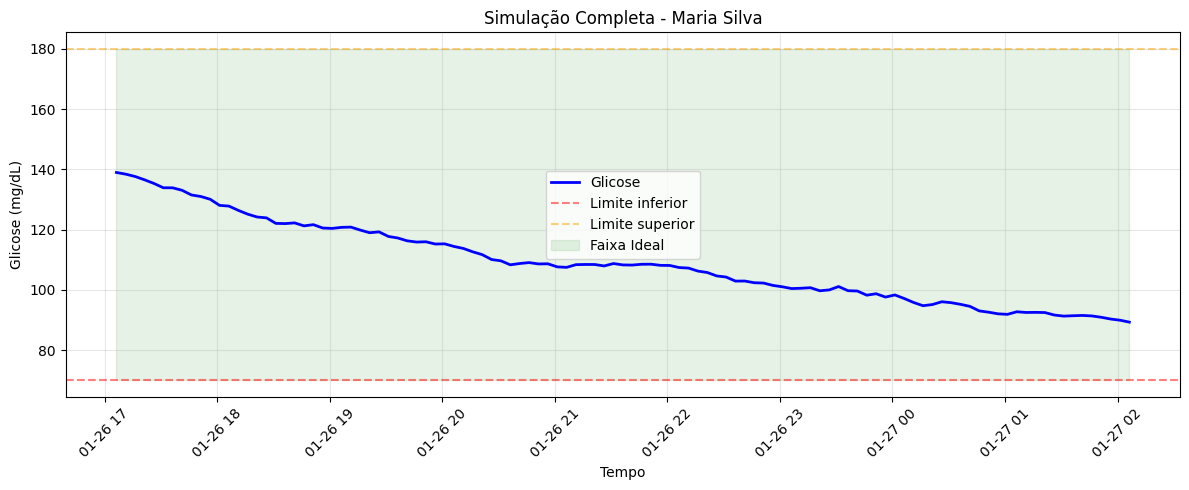

In [24]:
# ============================================
# 🚀 PASSO 7: SIMULAÇÃO EM TEMPO REAL
# ============================================

def run_complete_simulation(duration_minutes=5):
    """
    Executa simulação completa do paciente virtual em tempo real
    """
    print("\n" + "="*70)
    print("🚀 INICIANDO SIMULAÇÃO EM TEMPO REAL")
    print("="*70)

    # Criar paciente
    patient = VirtualPatient(
        name="Maria Silva",
        patient_type="moderate"
    )

    print(f"\n📋 CONFIGURAÇÃO:")
    print(f"   • Paciente: {patient.name}")
    print(f"   • Tipo: {patient.patient_type}")
    print(f"   • Duração: {duration_minutes} minutos")
    print(f"   • Atualizações: cada 5 segundos (simula 5 minutos)")
    print(f"   • Componentes: Dalla Man + Alertas" +
          (" + LSTM" if patient.lstm_model else ""))

    print("\n" + "="*70)
    print("🎬 INICIANDO EM 3... 2... 1...")
    print("="*70)

    time.sleep(2)

    try:
        # Executar simulação
        start_time = time.time()
        update_count = 0

        while time.time() - start_time < duration_minutes * 60:
            # Simular 5 minutos do paciente
            patient.simulate_minutes(minutes=5)

            # Mostrar dashboard
            patient.display_live_dashboard()

            update_count += 1

            # Aguardar para visualização (exceto última iteração)
            remaining = duration_minutes * 60 - (time.time() - start_time)
            if remaining > 2:
                print(f"\n⏳ Próxima atualização em 2 segundos...")
                time.sleep(2)

        print("\n" + "="*70)
        print("⏰ TEMPO DE SIMULAÇÃO ESGOTADO")
        print("="*70)

    except KeyboardInterrupt:
        print("\n\n⏹️ SIMULAÇÃO INTERROMPIDA PELO USUÁRIO")

    finally:
        # Mostrar resumo final
        print("\n" + "="*70)
        print("📊 RESUMO FINAL DA SIMULAÇÃO")
        print("="*70)

        if patient.history:
            glucose_values = [h['glucose'] for h in patient.history]

            print(f"\n📈 ESTATÍSTICAS DE {patient.name}:")
            print(f"   • Glicose média: {np.mean(glucose_values):.1f} mg/dL")
            print(f"   • Desvio padrão: {np.std(glucose_values):.1f} mg/dL")
            print(f"   • Mínima: {np.min(glucose_values):.1f} mg/dL")
            print(f"   • Máxima: {np.max(glucose_values):.1f} mg/dL")

            tir = sum(1 for g in glucose_values if 70 <= g <= 180) / len(glucose_values) * 100
            print(f"   • Tempo na meta: {tir:.1f}%")

            print(f"\n📊 DADOS COLETADOS:")
            print(f"   • Pontos totais: {len(patient.history)}")
            print(f"   • Eventos registrados: {len(patient.events_history)}")
            print(f"   • Alertas gerados: {len(patient.alert_system.alert_history)}")

        print("\n" + "="*70)
        print("✅ SIMULAÇÃO COMPLETA!")
        print("="*70)

        # Plot final
        if patient.history and len(patient.history) > 10:
            plt.figure(figsize=(12, 5))
            times = [h['timestamp'] for h in patient.history]
            glucose = [h['glucose'] for h in patient.history]

            plt.plot(times, glucose, 'b-', linewidth=2, label='Glicose')
            plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Limite inferior')
            plt.axhline(y=180, color='orange', linestyle='--', alpha=0.5, label='Limite superior')
            plt.fill_between(times, 70, 180, alpha=0.1, color='green', label='Faixa Ideal')

            # Marcar eventos
            event_times = []
            event_glucose = []
            for i, h in enumerate(patient.history):
                if h['events']:
                    event_times.append(h['timestamp'])
                    event_glucose.append(h['glucose'])

            if event_times:
                plt.scatter(event_times, event_glucose, color='red', s=50, zorder=5, label='Eventos')

            plt.title(f'Simulação Completa - {patient.name}')
            plt.xlabel('Tempo')
            plt.ylabel('Glicose (mg/dL)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# ============================================
# 🎬 EXECUTAR A SIMULAÇÃO
# ============================================

print("\n" + "="*70)
print("🎬 SISTEMA COMPLETO PRONTO!")
print("="*70)
print("\nO sistema inclui:")
print("1. 📦 Modelo Dalla Man modificado para DM2")
print("2. 🧠 LSTM com mecanismo de atenção")
print("3. ⚠️ Sistema de alertas clínicos")
print("4. 👤 Paciente virtual em tempo real")
print("5. 📊 Dashboard interativo")

print("\nDeseja executar a simulação?")
response = input("Digite 's' para sim (recomendado) ou 'n' para não: ")

if response.lower() == 's':
    run_complete_simulation(duration_minutes=5)  # 5 minutos de simulação
else:
    print("\n✅ Sistema pronto!")
    print("\nPara executar manualmente:")
    print("1. patient = VirtualPatient('Seu Nome', 'moderate')")
    print("2. patient.simulate_minutes(5)  # Simular 5 minutos")
    print("3. patient.display_live_dashboard()  # Ver dashboard")
    print("4. run_complete_simulation(10)  # Simulação de 10 min")